In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose, Dropout

In [2]:


def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):

    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    
    return model

In [3]:


# Könyvtárak definiálása
data_dir = "./mydataset/"
image_dir = os.path.join(data_dir, "images")
mask_dir = os.path.join(data_dir, "masks")

# Képek és maszkok betöltése és előfeldolgozása
images = sorted(glob(os.path.join(image_dir, "*.jpg")))
masks = sorted(glob(os.path.join(mask_dir, "*.png")))

train_images = []
train_masks = []

for img_path, mask_path in zip(images, masks):
    # Kép betöltése és előfeldolgozása
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Színkanális átalakítás RGB-re
    img = cv2.resize(img, (512, 512))  # Méret átméretezése a modell bemeneti méretére
    img = img / 255.0  # Normalizálás 0 és 1 között

    # Maszk betöltése és előfeldolgozása
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (512, 512))  # Méret átméretezése a modell bemeneti méretére
    mask = mask / 255.0  # Normalizálás 0 és 1 között

    train_images.append(img)
    train_masks.append(mask)

X = np.array(train_images)
y = np.expand_dims(np.array(train_masks), axis=-1)

# Adatok szétválasztása tanító és teszt halmazra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)



In [4]:
model = simple_unet_model(512, 512, 3)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 512, 512, 16  0           ['conv2d[0][0]']                 
                                )                                                             

In [5]:
summary = model.fit(X_train, y_train, batch_size=4, epochs=20, validation_data=(X_test, y_test))

Epoch 1/20
19/19 [==============================] - 24s 620ms/step - loss: 0.7533 - accuracy: 0.5372 - val_loss: 0.4333 - val_accuracy: 0.9150
Epoch 2/20
19/19 [==============================] - 6s 340ms/step - loss: 0.2233 - accuracy: 0.9402 - val_loss: 0.1812 - val_accuracy: 0.9150
Epoch 3/20
19/19 [==============================] - 6s 342ms/step - loss: 0.1455 - accuracy: 0.9404 - val_loss: 0.1690 - val_accuracy: 0.9150
Epoch 4/20
19/19 [==============================] - 7s 343ms/step - loss: 0.1256 - accuracy: 0.9389 - val_loss: 0.1257 - val_accuracy: 0.9090
Epoch 5/20
19/19 [==============================] - 6s 341ms/step - loss: 0.0967 - accuracy: 0.9263 - val_loss: 0.0927 - val_accuracy: 0.8980
Epoch 6/20
19/19 [==============================] - 6s 342ms/step - loss: 0.0838 - accuracy: 0.9251 - val_loss: 0.1058 - val_accuracy: 0.9074
Epoch 7/20
19/19 [==============================] - 6s 341ms/step - loss: 0.0696 - accuracy: 0.9289 - val_loss: 0.0726 - val_accuracy: 0.8943
Epoch

In [6]:
timage = cv2.imread("81.jpg", cv2.IMREAD_COLOR)
timage = timage / 255.0
timage = cv2.resize(timage, (512, 512))
timage = np.expand_dims(timage, axis=0)

In [7]:
predicted_mask = model.predict(timage)

1/1 [==============================] - 0s 347ms/step


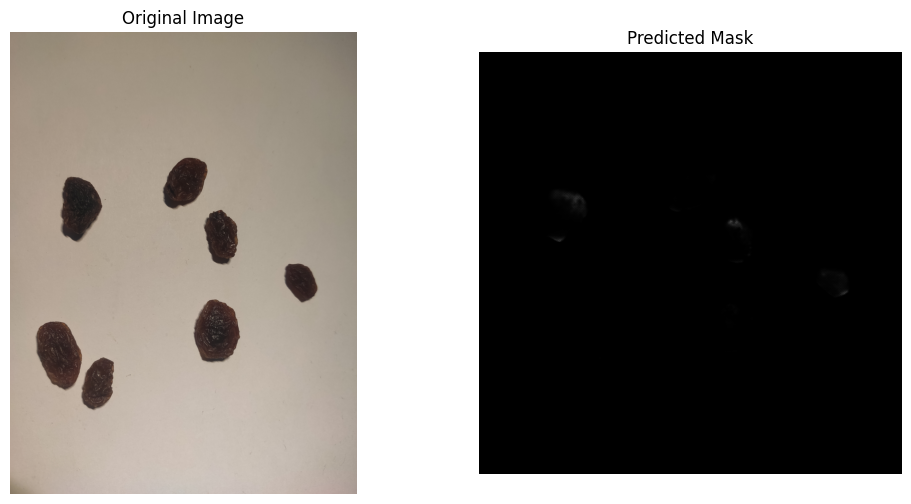

In [9]:

# Kép és maszk megjelenítése egymás mellett
plt.figure(figsize=(12, 6))

# Eredeti kép
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(cv2.imread("81.jpg"), cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

# Prediktált maszk
plt.subplot(1, 2, 2)
plt.imshow(predicted_mask[0],  cmap='gray', vmin=0, vmax=1)
plt.title('Predicted Mask')
plt.axis('off')

plt.show()